In [122]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div

## Relevant functions from utils.py

In [123]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

## Individual run

In [124]:
# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
print(df.shape)

# Find negative polarity interval measured by AMS02_h... in 20130221-20130319
# interval = '20130221-20130319'
# df_int = df[df.interval == interval]
# idx = df_int.index[0]
idx = 85
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load results from HMC run
# results_dir_hmc_0 = f'../../../results/v26/fulldataset.0/'
# results_dir_hmc_1 = f'../../../results/v26/fulldataset.1/'
train_size_fraction = 0.8
results_dir_hmc_0 = f'../../../results/v27/v1_{train_size_fraction}/'
results_dir_hmc_1 = f'../../../results/v27/v2_{train_size_fraction}/'
parameter_names = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

hmc_0_samples.columns = parameter_names
hmc_1_samples.columns = parameter_names

print(hmc_0_samples.head())
print(hmc_1_samples.head())

(133, 12)
Interval 20090308-20090403 corresponds to index 85 for neg polarity in PAMELA_H-ApJ2013.
          cpa   pwr1par  pwr1perp   pwr2par  pwr2perp
0  616.230225  0.457759  1.188245  1.339825  0.594292
1  654.800537  0.595008  1.216853  1.042533  0.511177
2  673.801758  1.425190  1.105461  1.230704  0.472109
3  642.226685  1.461798  1.052547  0.583818  0.580145
4  602.976440  0.743261  1.125940  0.457956  0.660019
          cpa   pwr1par  pwr1perp   pwr2par  pwr2perp
0  606.426758  1.074735  1.094248  1.411089  0.536148
1  619.201355  1.651386  1.002203  1.644785  0.497415
2  595.105225  0.606600  1.132702  1.545524  0.542503
3  646.797058  0.475403  1.227238  1.834313  0.434430
4  640.143127  1.159656  1.114686  1.140256  0.627372


KL divergence for cpa: 0.055563565292800564
KL divergence for pwr1par: 0.004182160774699516
KL divergence for pwr1perp: 0.022932754519287953
KL divergence for pwr2par: 0.0027248376044923584
KL divergence for pwr2perp: 0.0019238200665425147


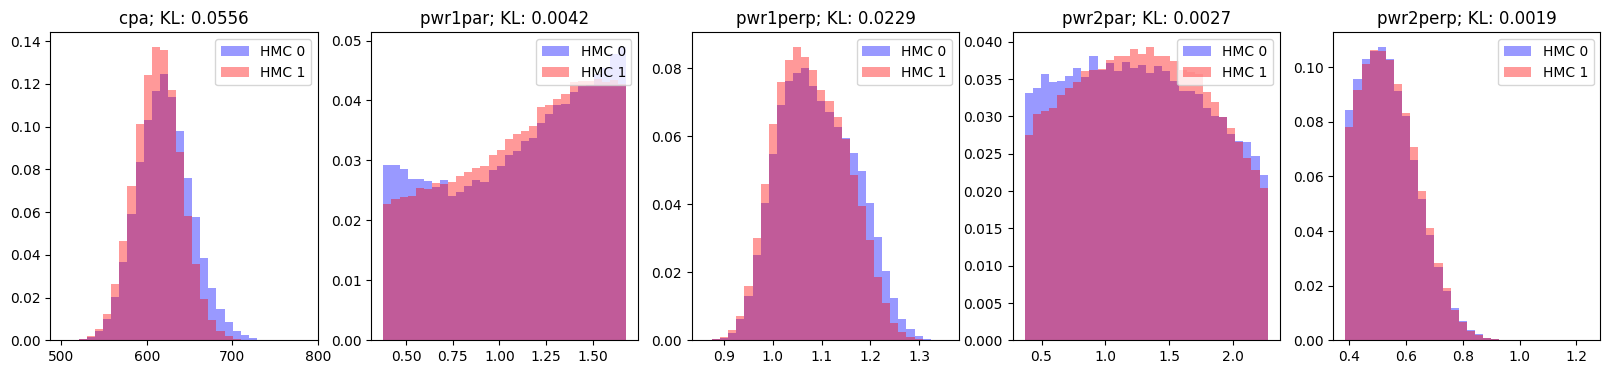

In [125]:
num_bins = 30

# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Plot the samples
kl_divergences = []
for i, param in enumerate(parameter_names):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values

    # Plot the samples with same bins
    total_list = np.concatenate((samples_0, samples_1), axis=0)
    min = np.min(total_list)
    max = np.max(total_list)

    # Create histograms and plot
    hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
    hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

    # Adjust histograms to avoid zero values
    epsilon = 1e-10  # Small constant to prevent zeros
    hist_0 += epsilon
    hist_1 += epsilon

    # Ensure both hists sum to 1
    hist_0 /= hist_0.sum()
    hist_1 /= hist_1.sum()
    assert np.isclose(hist_0.sum(), 1.0), f"Histogram 0 does not sum to 1: {hist_0.sum()}"
    assert np.isclose(hist_1.sum(), 1.0), f"Histogram 1 does not sum to 1: {hist_1.sum()}"

    # Compute KL divergence
    kl_divergence = np.sum(rel_entr(hist_0, hist_1))
    print(f"KL divergence for {param}: {kl_divergence}")
    kl_divergences.append(kl_divergence)

    # Plot the histograms
    axs[i].bar(bins[:-1], hist_0, width=(bins[1]-bins[0]), alpha=0.4, label='HMC 0', color='blue')
    axs[i].bar(bins[:-1], hist_1, width=(bins[1]-bins[0]), alpha=0.4, label='HMC 1', color='red')

    # Set the title and labels
    axs[i].set_title(f"{param}; KL: {kl_divergence:.4f}")
    axs[i].legend(loc='upper right')

plt.show()

## All the runs

In [126]:
train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
parameter_names = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']
num_bins = 30

kl_divergences = {}

# Calculate the k;_divergence for each parameter and train size
for i, train_size_fraction in enumerate(train_fractions):
    if train_size_fraction == 1.0:
        results_dir_hmc_0 = f'../../../results/v26/fulldataset.0/'
        results_dir_hmc_1 = f'../../../results/v26/fulldataset.1/'
    else:
        results_dir_hmc_0 = f'../../../results/v27/v1_{train_size_fraction}/'
        results_dir_hmc_1 = f'../../../results/v27/v2_{train_size_fraction}/'

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

    hmc_0_samples.columns = parameter_names
    hmc_1_samples.columns = parameter_names

    for param in parameter_names:
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values

        # Plot the samples with same bins
        total_list = np.concatenate((samples_0, samples_1), axis=0)
        min = np.min(total_list)
        max = np.max(total_list)

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

        # Adjust histograms to avoid zero values
        epsilon = 1e-10  # Small constant to prevent zeros
        hist_0 += epsilon
        hist_1 += epsilon

        # Ensure both hists sum to 1
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()
        assert np.isclose(hist_0.sum(), 1.0), f"Histogram 0 does not sum to 1: {hist_0.sum()}"
        assert np.isclose(hist_1.sum(), 1.0), f"Histogram 1 does not sum to 1: {hist_1.sum()}"

        # Compute KL divergence
        kl_divergence = np.sum(rel_entr(hist_0, hist_1))
        kl_divergences.setdefault(param, []).append(kl_divergence)
        print(f"KL divergence for {param} at train size {train_size_fraction}: {kl_divergence}")

KL divergence for cpa at train size 0.0001: 2.567129009099631
KL divergence for pwr1par at train size 0.0001: 0.9838185024737461
KL divergence for pwr1perp at train size 0.0001: 0.5584314174739948
KL divergence for pwr2par at train size 0.0001: 23.574859361934468
KL divergence for pwr2perp at train size 0.0001: 15.593080999261232
KL divergence for cpa at train size 0.001: 1.3115731781935178
KL divergence for pwr1par at train size 0.001: 4.942527411106672
KL divergence for pwr1perp at train size 0.001: 6.21933785597131
KL divergence for pwr2par at train size 0.001: 9.929440326535747
KL divergence for pwr2perp at train size 0.001: 0.050113063189974466
KL divergence for cpa at train size 0.01: 1.676513067502521
KL divergence for pwr1par at train size 0.01: 3.157307344462054
KL divergence for pwr1perp at train size 0.01: 1.0131777613219133
KL divergence for pwr2par at train size 0.01: 1.2778109214731708
KL divergence for pwr2perp at train size 0.01: 1.8567638670751616
KL divergence for cpa

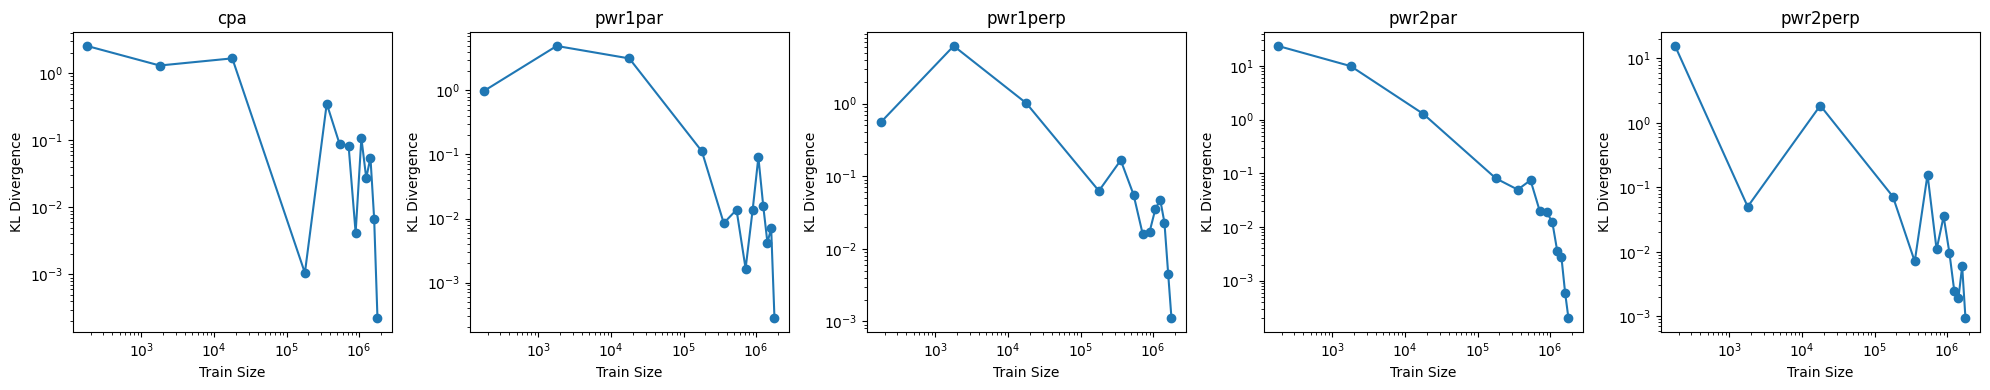

In [127]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
data_train_fractions = np.array(train_fractions) * 1_788_892  # Scale to the number of data points in the full dataset

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.plot(data_train_fractions, kl_divergences[param], marker='o')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel('KL Divergence')
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

## Now calculate the average over all 0-132 runs

In [ ]:
# Calculate the kl-divergence, but take average over the 133 runs
# Load all of the intervals
df = index_mcmc_runs(file_version='2023')

# Only keep 'neg' polarity
df = df[df.polarity == 'neg'].copy(deep=True)
print(df.shape)

train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
parameter_names = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']
output_file = f'../../../results/v27/kl_divergence_v1v2.csv'
write_new_file = False

(133, 12)


In [129]:
num_bins = 30

# Create a file to write the KL divergence to
if write_new_file:
    with open(output_file, 'w') as f:
        f.write("train_size_fraction,param,df_index,kl_divergence\n")

    # Calculate the k;_divergence for each parameter and train size
    for i, train_size_fraction in enumerate(train_fractions):
        print(f"\n-----------------\nProcessing train size fraction {train_size_fraction}...")
        if train_size_fraction == 1.0:
            results_dir_hmc_0 = f'../../../results/v26/fulldataset.0/'
            results_dir_hmc_1 = f'../../../results/v26/fulldataset.1/'
        else:
            results_dir_hmc_0 = f'../../../results/v27/v1_{train_size_fraction}/'
            results_dir_hmc_1 = f'../../../results/v27/v2_{train_size_fraction}/'

        for param in parameter_names:
            # Load the samples from each hmc run, get average per parameter and stdev
            print(f"\nProcessing parameter {param}...")
            for idx in range(df.shape[0]):
                print(f"Processing df index {idx} for parameter {param} and train_size_fraction {train_size_fraction}...")
                # Load info from the df for index idx
                exp_name = df.experiment_name.iloc[idx]
                interval = df.interval.iloc[idx]
                polarity = df.polarity.iloc[idx]

                # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
                # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
                try:
                    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                except FileNotFoundError:
                    print(f"File not found for index {idx}, experiment {exp_name}, interval {interval}, polarity {polarity}. Skipping.")
                    continue

                hmc_0_samples.columns = parameter_names
                hmc_1_samples.columns = parameter_names
                
                samples_0 = hmc_0_samples[param].values
                samples_1 = hmc_1_samples[param].values

                # Plot the samples with same bins
                total_list = np.concatenate((samples_0, samples_1), axis=0)
                min = np.min(total_list)
                max = np.max(total_list)

                # Create histograms and plot
                hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
                hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

                # Adjust histograms to avoid zero values
                epsilon = 1e-10  # Small constant to prevent zeros
                hist_0 += epsilon
                hist_1 += epsilon

                # Ensure both hists sum to 1
                hist_0 /= hist_0.sum()
                hist_1 /= hist_1.sum()
                assert np.isclose(hist_0.sum(), 1.0), f"Histogram 0 does not sum to 1: {hist_0.sum()}"
                assert np.isclose(hist_1.sum(), 1.0), f"Histogram 1 does not sum to 1: {hist_1.sum()}"

                # Compute KL divergence
                kl_divergence = np.sum(rel_entr(hist_0, hist_1))

                # Write the KL divergence for this train_size_fraction, parameter, and index to a file
                with open(output_file, 'a') as f:
                    f.write(f"{train_size_fraction},{param},{idx},{kl_divergence}\n")

In [130]:
avg_kl_divergences = {}
std_kl_divergences = {}

# Read the KL divergence from the file
df_kl = pd.read_csv(output_file)
for param in parameter_names:
    # Get the KL divergence for this parameter
    df_param = df_kl[df_kl.param == param]

    # Get the average KL divergence for each train size
    avg_kl_divergence = df_param.groupby('train_size_fraction')['kl_divergence'].mean().values
    std_kl_divergence = df_param.groupby('train_size_fraction')['kl_divergence'].std().values

    avg_kl_divergences.setdefault(param, []).append(avg_kl_divergence)
    std_kl_divergences.setdefault(param, []).append(std_kl_divergence)

print(avg_kl_divergences)

{'cpa': [array([1.38915169e+01, 1.05853784e+01, 4.33933867e+00, 1.03025679e+00,
       4.29345988e-01, 3.40977401e-01, 1.55775612e+00, 8.40602200e-01,
       2.04145744e-01, 1.69586338e+00, 6.81226990e-01, 3.45953185e-01,
       3.31665002e-04])], 'pwr1par': [array([1.19973413e+01, 1.37820162e+01, 5.41323877e+00, 3.12008529e-01,
       2.16256499e-01, 2.94481997e-01, 1.72072449e-01, 4.08616036e-01,
       1.17569426e-01, 1.73024819e-01, 2.64402413e-01, 7.81130899e-02,
       2.62411502e-04])], 'pwr1perp': [array([1.51095801e+01, 1.36465429e+01, 5.58317958e+00, 4.51626091e-01,
       2.33254129e-01, 1.98092809e-01, 9.58785715e-01, 4.58276198e-01,
       1.14939645e-01, 4.44635186e-01, 6.12927370e-01, 1.11792904e-01,
       3.11040455e-04])], 'pwr2par': [array([1.88713583e+01, 1.55847929e+01, 4.66537943e+00, 6.89322904e-01,
       1.88267651e-01, 2.24509401e-01, 5.06399944e-02, 9.23400859e-02,
       1.24044403e-01, 8.34112111e-02, 6.16004857e-02, 4.93799943e-02,
       2.62291680e-04])]

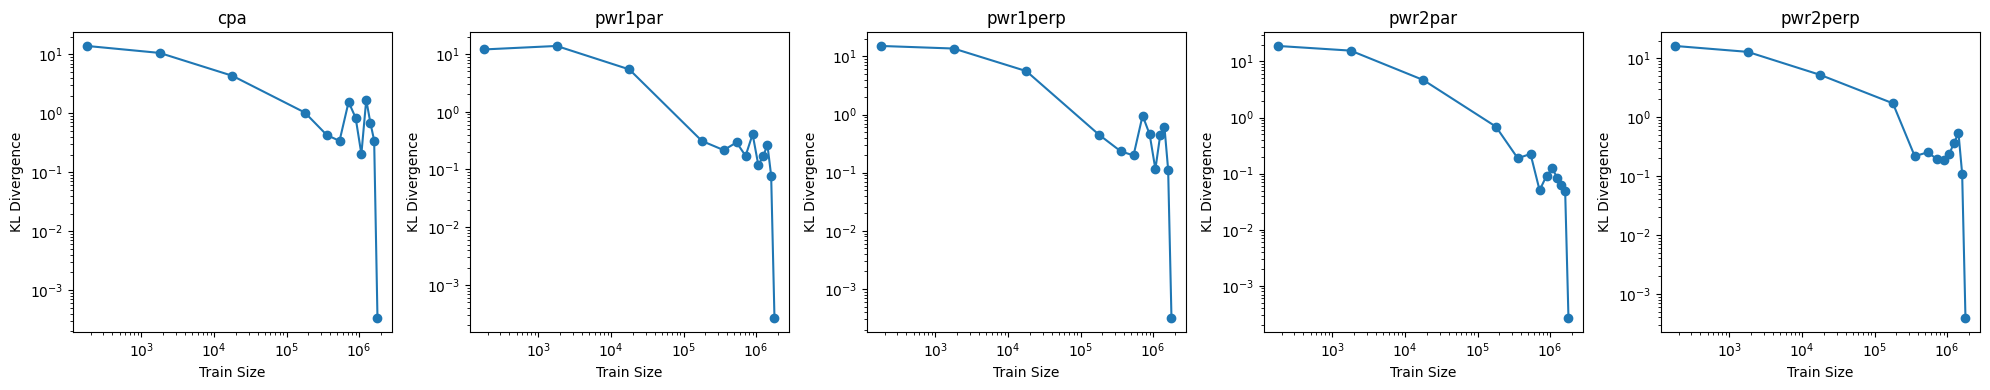

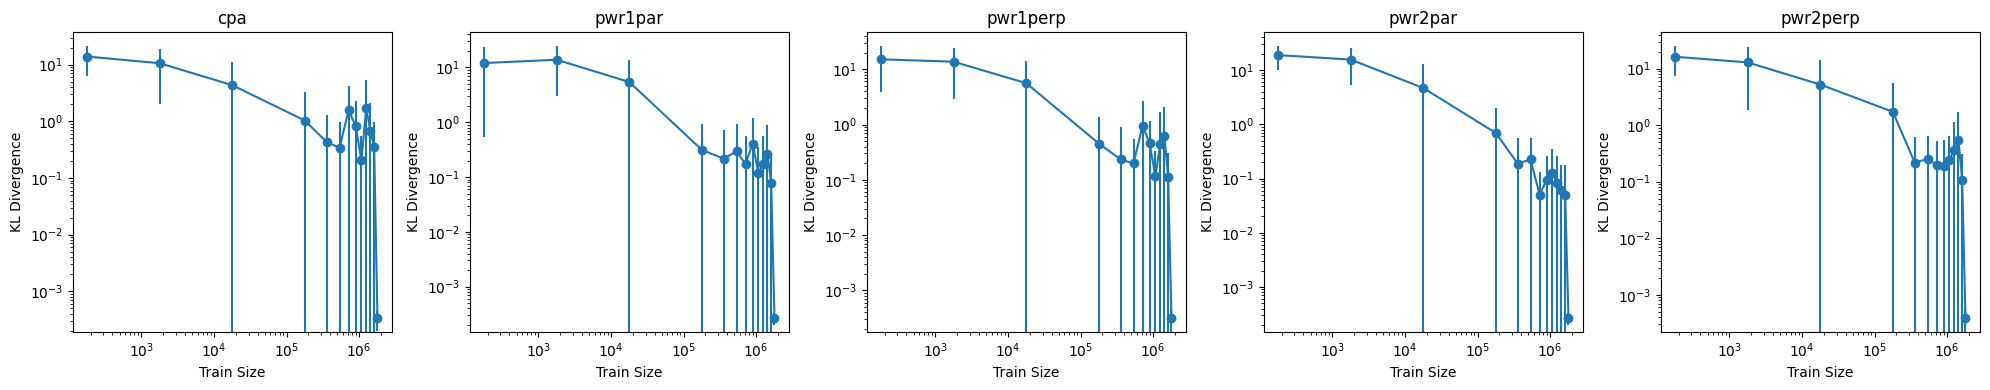

In [ ]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
train_sizes = np.array(train_fractions) * 1_788_892

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.plot(train_sizes, avg_kl_divergences[param][0], marker='o')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel('KL Divergence')
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
train_sizes = np.array(train_fractions) * 1_788_892

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.errorbar(train_sizes, avg_kl_divergences[param][0], yerr=std_kl_divergences[param][0], marker='o')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel('KL Divergence')
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()